<a href="https://colab.research.google.com/github/aelmah/Energy_forecasting/blob/main/Energy_Consumption_Forecasting_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Energy Consumption Forecasting***

### 1. Initial Setup and Library Imports

This section imports all the necessary libraries for data manipulation, numerical operations, plotting, machine learning model building (specifically LSTM with Keras), and data scaling.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

### 2. Data Acquisition from KaggleHub

Here, we use `kagglehub` to download the 'hourly-energy-consumption' dataset. This ensures we are working with the latest version of the data. We then list the files to identify the specific CSV file we'll be using, which is `AEP_hourly.csv`.

In [ ]:
!pip install kagglehub -q

import kagglehub
import os

# Téléchargement de la dernière version du dataset
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)
# Liste les fichiers pour trouver 'AEP_hourly.csv'
print("Fichiers disponibles :", os.listdir(path))

Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.
Path to dataset files: /kaggle/input/hourly-energy-consumption
Fichiers disponibles : ['est_hourly.paruqet', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'COMED_hourly.csv', 'AEP_hourly.csv', 'pjm_hourly_est.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']


### 3. Building and Training a Univariate LSTM Model (Single-Step Prediction)

This section focuses on constructing a basic LSTM model to predict the next hour's energy consumption based *only* on past consumption data. It involves several key steps:

*   **Data Loading and Preparation**: Reading the `AEP_hourly.csv` file, converting the `Datetime` column to a proper datetime index, and sorting the data chronologically.
*   **Feature Engineering (Initial)**: Extracting `hour` and `dayofweek` from the datetime index. While these are generated, the first model will primarily use `AEP_MW`.
*   **Normalization**: Scaling the `AEP_MW` feature using `MinMaxScaler` to bring values between 0 and 1, which is crucial for neural networks.
*   **Sequence Creation**: Transforming the time series data into sequences suitable for LSTM input, where each input `X` consists of a window of 24 previous hours, and the target `y` is the consumption at the 25th hour.
*   **Train/Test Split**: Dividing the data into training and testing sets (80% train, 20% test).
*   **LSTM Model Definition**: Setting up a Sequential Keras model with two LSTM layers, Dropout for regularization, and a Dense output layer for single-step prediction.
*   **Model Compilation and Training**: Configuring the model with the 'adam' optimizer and 'mse' (Mean Squared Error) loss, then training it on the prepared data.
*   **Prediction and Visualization**: Making predictions on the test set, inverse-transforming them to original MW units, and plotting a comparison of actual vs. predicted values for a small segment.

Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - loss: 0.0105 - val_loss: 5.4009e-04
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 7.0544e-04 - val_loss: 3.9182e-04
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 5.4011e-04 - val_loss: 4.0284e-04
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 4.5368e-04 - val_loss: 5.4898e-04
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 4.4838e-04 - val_loss: 2.5385e-04
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 3.8568e-04 - val_loss: 2.7656e-04
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 3.6542e-04 - val_loss: 2.1902e-04
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 3.4190e-04 - val_loss: 3.0127e-04
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 3.2321e-04 - val_loss: 3.5620e-04
Epoch 10/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 3.1423e-04 - val_loss: 1.9371e-04
758/758 ━━━━━━━━━━━━━━━

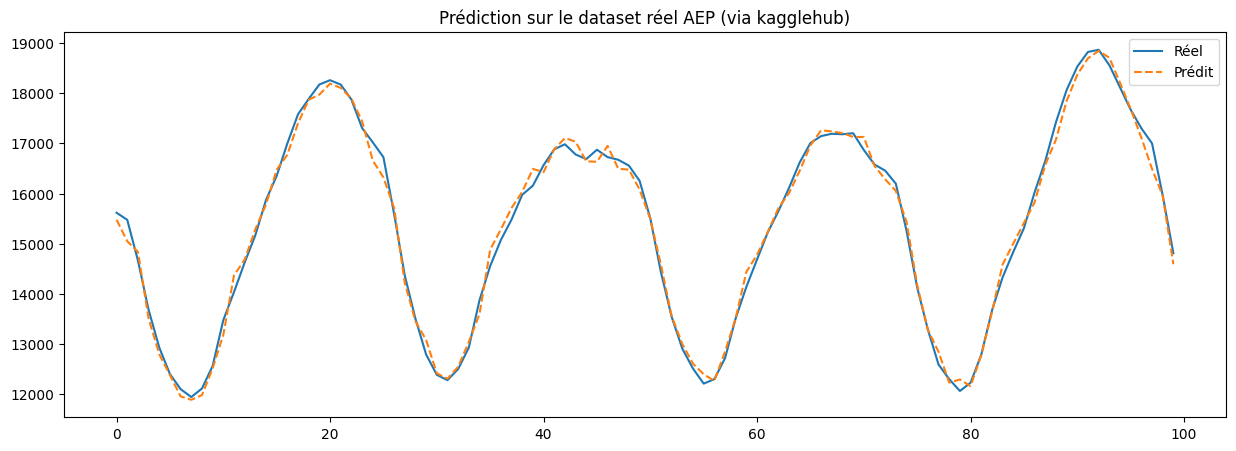

In [ ]:
# 1. Chargement dynamique du fichier réel
file_path = os.path.join(path, "AEP_hourly.csv")
df = pd.read_csv(file_path)

# Préparation : On met la date en index et on trie (crucial pour les séries temporelles)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

# 2. Feature Engineering simple (Optionnel mais recommandé)
# Extraire l'heure et le jour peut aider le modèle
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# 3. Normalisation
scaler = MinMaxScaler()
# On normalise la consommation (AEP_MW)
scaled_data = scaler.fit_transform(df[['AEP_MW']])

# 4. Création des séquences (Look back de 24h)
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, 0])
        y.append(data[i+window, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split Train/Test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Modèle LSTM
model = Sequential([
    Input(shape=(24, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# 6. Prédiction et Visualisation
predictions = model.predict(X_test)
predictions_mw = scaler.inverse_transform(predictions)
y_test_mw = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(15, 5))
plt.plot(y_test_mw[-100:], label="Réel")
plt.plot(predictions_mw[-100:], label="Prédit", linestyle='--')
plt.title("Prédiction sur le dataset réel AEP (via kagglehub)")
plt.legend()
plt.show()

### 4. Enhancing the Model with Multivariate Features (Single-Step Prediction)

To potentially improve prediction accuracy, we now incorporate additional features beyond just past consumption. This model considers 'hour' and 'dayofweek' as inputs alongside 'AEP_MW'.

*   **Feature Engineering**: Normalizing 'hour' and 'dayofweek' to a 0-1 range.
*   **Multivariate Data Preparation**: Selecting 'AEP_MW', 'hour', and 'dayofweek' as features.
*   **Multivariate Normalization**: Scaling all selected features using a new `MinMaxScaler` instance.
*   **Multivariate Sequence Creation**: Creating sequences where each input `X` now contains 24 past hours of *all three features*, but the target `y` remains the next hour's `AEP_MW`.
*   **Train/Test Split**: Splitting the multivariate sequences into training and testing sets.
*   **Multivariate LSTM Model Definition and Training**: Defining a new LSTM model that can handle the increased input features (input shape will be `(24, 3)` instead of `(24, 1)`) and training it.

In [ ]:
# 1. Préparation des colonnes supplémentaires
df['hour'] = df.index.hour / 23.0  # Normalisation simple entre 0 et 1
df['dayofweek'] = df.index.dayofweek / 6.0

# On sélectionne nos colonnes pour l'entraînement
features = ['AEP_MW', 'hour', 'dayofweek']
data_multivariate = df[features].values

# 2. Normalisation de toutes les colonnes
scaler_multi = MinMaxScaler()
scaled_data_multi = scaler_multi.fit_transform(data_multivariate)

# 3. Création des séquences multivariées
def create_multivariate_sequences(data, window=24):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :]) # On prend toutes les colonnes (consommation, heure, jour)
        y.append(data[i+window, 0])    # On ne prédit que la consommation (index 0)
    return np.array(X), np.array(y)

X_m, y_m = create_multivariate_sequences(scaled_data_multi)

# 4. Split et nouveau Modèle
split = int(len(X_m) * 0.8)
X_train_m, X_test_m = X_m[:split], X_m[split:]
y_train_m, y_test_m = y_m[:split], y_m[split:]

model_multi = Sequential([
    Input(shape=(X_train_m.shape[1], X_train_m.shape[2])), # (24, 3) au lieu de (24, 1)
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_multi.compile(optimizer='adam', loss='mse')
model_multi.fit(X_train_m, y_train_m, epochs=15, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 0.0092 - val_loss: 6.4663e-04
Epoch 2/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 8.0718e-04 - val_loss: 3.1754e-04
Epoch 3/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 5.2724e-04 - val_loss: 2.7057e-04
Epoch 4/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 4.4829e-04 - val_loss: 3.0578e-04
Epoch 5/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 3.8156e-04 - val_loss: 6.2063e-04
Epoch 6/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 3.7280e-04 - val_loss: 3.7137e-04
Epoch 7/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 3.4424e-04 - val_loss: 2.1589e-04
Epoch 8/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 2.9929e-04 - val_loss: 3.4711e-04
Epoch 9/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 2.6738e-04 - val_loss: 4.0218e-04
Epoch 10/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 2.7254e-04 - val_loss: 1.9120e-04
Epoch 11/15
1365/1365 ━

### 5. Evaluating the Multivariate Model

After training the multivariate model, we evaluate its performance on the test set using standard regression metrics: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

*   **Prediction**: Generating predictions on the test data.
*   **Inverse Transformation**: Reversing the normalization to get predictions and actual values back in their original MW scale. This is a crucial step for interpretable error metrics.
*   **Metric Calculation**: Computing MAE and RMSE to quantify the model's accuracy.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prédictions sur le jeu de test
predictions_m = model_multi.predict(X_test_m)

# Inverser la normalisation pour revenir aux vraies valeurs (MW)
# Note: On doit inverser uniquement la colonne de consommation (index 0)
# Pour cela, on crée un dummy array pour le scaler
dummy = np.zeros((len(predictions_m), len(features)))
dummy[:, 0] = predictions_m[:, 0]
predictions_inv = scaler_multi.inverse_transform(dummy)[:, 0]

dummy_y = np.zeros((len(y_test_m), len(features)))
dummy_y[:, 0] = y_test_m
y_test_inv = scaler_multi.inverse_transform(dummy_y)[:, 0]

# Calcul des scores
mae = mean_absolute_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))

print(f"--- Résultats du Modèle Multivarié ---")
print(f"Erreur Moyenne (MAE) : {mae:.2f} MW")
print(f"Erreur Racine Carrée (RMSE) : {rmse:.2f} MW")

758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
--- Résultats du Modèle Multivarié ---
Erreur Moyenne (MAE) : 148.65 MW
Erreur Racine Carrée (RMSE) : 197.07 MW


### 6. Analyzing Prediction Error Distribution

To understand the nature of the model's errors, we visualize their distribution using a histogram. This helps in identifying if errors are centered around zero, if there's a bias, or if there are significant outliers.

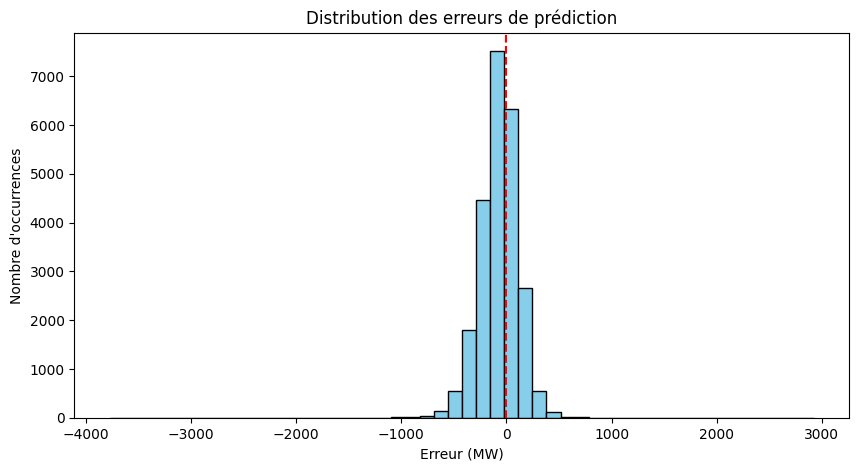

In [ ]:
errors = y_test_inv - predictions_inv

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Erreur (MW)")
plt.ylabel("Nombre d'occurrences")
plt.axvline(0, color='red', linestyle='--')
plt.show()

### 7. Saving the Trained Model and Scaler

To make the trained model reusable without retraining, we save it to disk. It's also critical to save the `MinMaxScaler` used for normalization, as it will be needed to preprocess any new data before making predictions and to inverse-transform predictions back to the original scale.

In [ ]:
# Sauvegarde du modèle au format Keras
model_multi.save('model_consommation_AEP.keras')

# Sauvegarde du scaler (important pour normaliser les nouvelles données futures)
import joblib
joblib.dump(scaler_multi, 'scaler_AEP.pkl')

print("Modèle et Scaler sauvegardés avec succès !")

Modèle et Scaler sauvegardés avec succès !


### 8. Downloading Saved Assets

This step allows you to download the saved Keras model file (`.keras`) and the scaler object (`.pkl`) directly from the Colab environment to your local machine.

In [ ]:
from google.colab import files
files.download('model_consommation_AEP.keras')
files.download('scaler_AEP.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

24 **Hours**

### 9. Building a Multi-Step LSTM Model (24-Hour Horizon Prediction)

This section builds a more advanced model designed to predict *multiple future time steps simultaneously* – specifically, the next 24 hours of energy consumption. This differs from the previous models that predicted only the immediate next hour.

*   **Data Preparation**: Re-loading and preparing the data, including feature engineering and normalization, similar to the multivariate model.
*   **Multi-Step Sequence Creation**: A new `create_multi_step_sequences` function is introduced. It takes 24 past hours of all features as input (`X`) and targets the `AEP_MW` values for the *next 24 consecutive hours* (`y`).
*   **Train/Test Split**: Splitting the multi-step sequences.
*   **Multi-Step LSTM Model Definition**: The model's output layer is modified to have 24 units, allowing it to predict 24 values at once.
*   **Model Compilation and Training**: Compiling and training this specialized multi-step prediction model.
*   **Prediction and Inverse Transformation**: Generating 24-hour horizon predictions and using a custom `inverse_transform_multi` function to revert them to original MW units.
*   **Evaluation and Visualization**: Calculating MAE and RMSE for the multi-step predictions and visualizing a sample 24-hour prediction against the actual values. An error distribution for this model is also plotted.

In [ ]:
# 1. Chargement dynamique du fichier réel
file_path = os.path.join(path, "AEP_hourly.csv")
df = pd.read_csv(file_path)

Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.
Début de l'entraînement...
Epoch 1/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 97s 69ms/step - loss: 0.0133 - val_loss: 0.0033
Epoch 2/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 3/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 91s 67ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 93s 68ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 67ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 90s 66ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 96s 70ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 91s 66ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 91s 66ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 91s 67ms/step - loss: 0.0021 - val_los

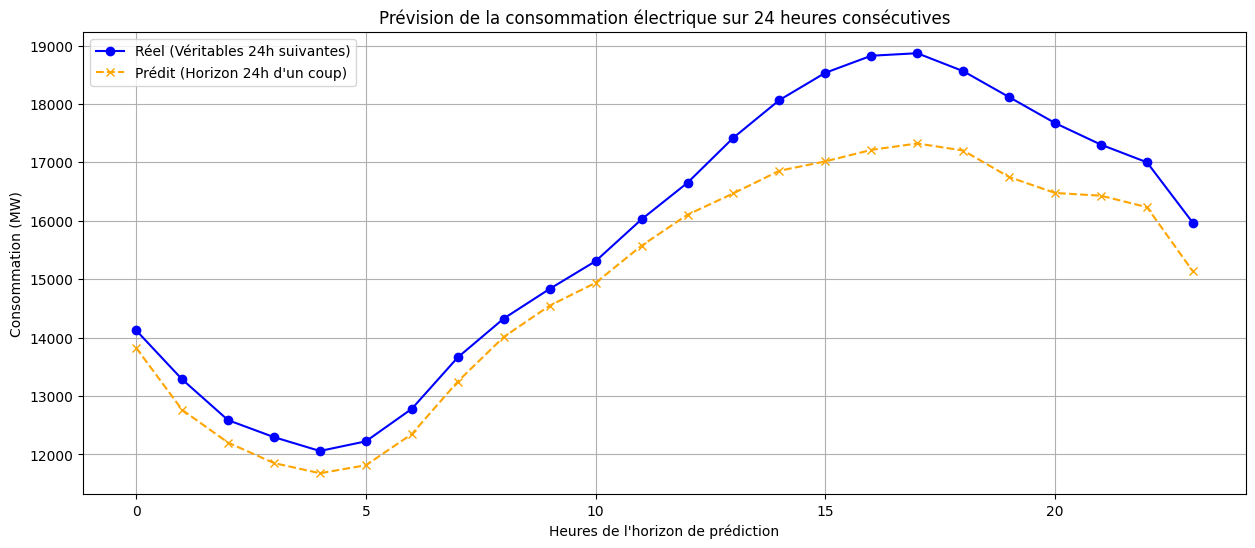

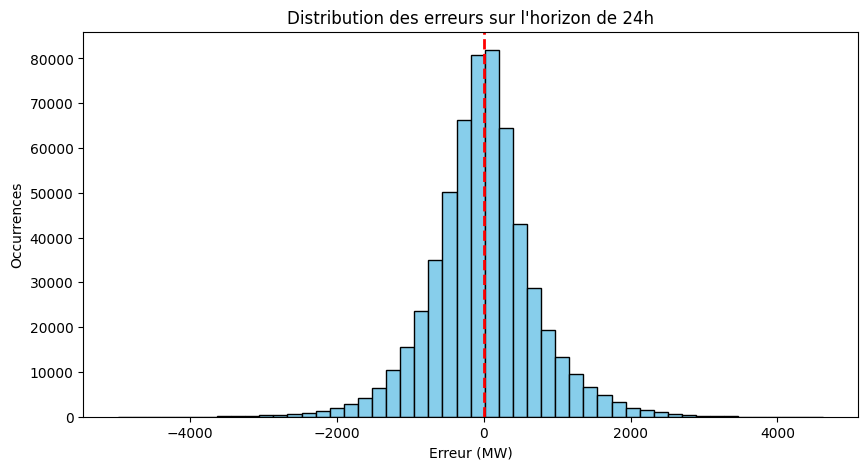

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Chargement et Préparation des Données ---
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
file_path = os.path.join(path, "AEP_hourly.csv")
df = pd.read_csv(file_path)

# Conversion de la date et tri (Essentiel pour éviter l'erreur d'index)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

# Feature Engineering
df['hour'] = df.index.hour / 23.0
df['dayofweek'] = df.index.dayofweek / 6.0

features = ['AEP_MW', 'hour', 'dayofweek']
data_multivariate = df[features].values

# Normalisation
scaler_multi = MinMaxScaler()
scaled_data_multi = scaler_multi.fit_transform(data_multivariate)

# --- 2. Création des séquences Multi-Step (24h passées -> 24h futures) ---
def create_multi_step_sequences(data, window=24, horizon=24):
    X, y = [], []
    for i in range(len(data) - window - horizon):
        X.append(data[i:i+window, :])                # Input: les 24h précédentes (toutes features)
        y.append(data[i+window:i+window+horizon, 0]) # Target: les 24h suivantes (conso uniquement)
    return np.array(X), np.array(y)

X_m, y_m = create_multi_step_sequences(scaled_data_multi)

# Split Train/Test
split = int(len(X_m) * 0.8)
X_train, X_test = X_m[:split], X_m[split:]
y_train, y_test = y_m[:split], y_m[split:]

# --- 3. Construction du Modèle LSTM Horizon 24h ---
model_horizon = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # (24, 3)
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(24) # Sortie : prédiction de 24 points simultanés
])

model_horizon.compile(optimizer='adam', loss='mse')
print("Début de l'entraînement...")
history = model_horizon.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1, verbose=1)

# --- 4. Prédiction et Inversion de la Normalisation ---
predictions = model_horizon.predict(X_test)

def inverse_transform_multi(scaled_predictions, scaler, n_features):
    # mémorise la forme originale (N_lignes, 24)
    original_shape = scaled_predictions.shape
    # Aplatit pour passer par le scaler (N_lignes * 24, 1)
    flat_preds = scaled_predictions.reshape(-1, 1)

    # Création d'un tableau dummy avec le nombre de colonnes d'origine (3)
    dummy = np.zeros((len(flat_preds), n_features))
    dummy[:, 0] = flat_preds[:, 0] # On place nos prédictions dans la colonne 0 (AEP_MW)

    # Inversion
    inv_flat = scaler.inverse_transform(dummy)[:, 0]
    # Retour à la forme (N_lignes, 24)
    return inv_flat.reshape(original_shape)

predictions_mw = inverse_transform_multi(predictions, scaler_multi, len(features))
y_test_mw = inverse_transform_multi(y_test, scaler_multi, len(features))

# --- 5. Évaluation et Visualisation ---
mae = mean_absolute_error(y_test_mw, predictions_mw)
rmse = np.sqrt(mean_squared_error(y_test_mw, predictions_mw))

print(f"\n--- RÉSULTATS DU MODÈLE HORIZON 24H ---")
print(f"Erreur Moyenne (MAE) : {mae:.2f} MW")
print(f"RMSE : {rmse:.2f} MW")

# Visualisation d'un échantillon au hasard (ex: le dernier jour du set de test)
plt.figure(figsize=(15, 6))
plt.plot(y_test_mw[-1], label="Réel (Véritables 24h suivantes)", color='blue', marker='o')
plt.plot(predictions_mw[-1], label="Prédit (Horizon 24h d'un coup)", color='orange', linestyle='--', marker='x')
plt.title("Prévision de la consommation électrique sur 24 heures consécutives")
plt.xlabel("Heures de l'horizon de prédiction")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.grid(True)
plt.show()

# Histogramme des erreurs pour le multi-step
errors = (y_test_mw - predictions_mw).flatten()
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, edgecolor='black', color='skyblue')
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.title("Distribution des erreurs sur l'horizon de 24h")
plt.xlabel("Erreur (MW)")
plt.ylabel("Occurrences")
plt.show()